# Looking at SHAP values for a linear model : sklearn's LinearRegression

In [67]:
import pandas
import sklearn
from sklearn import model_selection, linear_model, preprocessing, metrics
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import r2_score, classification_report, confusion_matrix, mean_squared_error, mean_absolute_error
import numpy as np

In [27]:
rxns_df = pandas.read_csv("godineau2023_reactions_with_yields.tsv", sep='\t')
rxns_df_x = rxns_df.drop("Yield of 3aa", axis = 1)
rxns_df_x = rxns_df_x.drop("Conversion of 1a", axis = 1)
rxns_df_y = rxns_df[["Yield of 3aa"]]

In [28]:
numerical_features = rxns_df_x.select_dtypes(include=['int','float']).columns
categorical_features = rxns_df_x.select_dtypes(include=['object']).columns
label_encoders={}
for feature in categorical_features:
    label_encoders[feature]=LabelEncoder()
    rxns_df_x[feature] = label_encoders[feature].fit_transform(rxns_df_x[feature])
#prepping y
numerical_features_y = rxns_df_y.select_dtypes(include=['int','float']).columns
categorical_features_y = rxns_df_y.select_dtypes(include=['object']).columns
label_encoders_y={}
for feature in categorical_features_y:
    label_encoders[feature]=LabelEncoder()
    rxns_df_y[feature] = label_encoders_y[feature].fit_transform(rxns_df_y[feature])
x_train, x_temp, y_train, y_temp = train_test_split(rxns_df_x, rxns_df_y, test_size=0.3, random_state=42)
x_val, x_test, y_val, y_test = train_test_split(x_temp, y_temp, test_size=0.5,random_state=42)

In [29]:
model = LinearRegression()
model.fit(x_train, y_train)

LinearRegression()

In [30]:
#validation
y_val_pred = model.predict(x_val)
#accuracy = model.score(y_val_pred, y_val)
accuracy = r2_score(y_val, y_val_pred)
print(f'Validation Accuracy with r2 :{accuracy}')
MAE_val = mean_absolute_error(y_val, y_val_pred)
RMSE_val = np.sqrt(mean_squared_error(y_val, y_val_pred))
print(f"Validation RMSE:{RMSE_val}")
print(f'Validation MAE:{MAE_val}')

#testing
y_test_pred = model.predict(x_test)
accuracy_test = r2_score(y_test, y_test_pred)
#accuracy_test = model.score(y_test_pred, y_test)
print(f'Test Set Accuracy with r2 : {accuracy_test}')
MAE_test = mean_absolute_error(y_test, y_test_pred)
RMSE_test = np.sqrt(mean_squared_error(y_test, y_test_pred))
print(f"Test RMSE:{RMSE_test}")
print(f'Test MAE:{MAE_test}')

Validation Accuracy with r2 :0.38674994024004994
Validation RMSE:16.010390645183502
Validation MAE:13.205783539458864
Test Set Accuracy with r2 : 0.18998914534432554
Test RMSE:19.384414828887646
Test MAE:14.749787048765715


In [33]:
import shap

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [34]:
import shap
explainer = shap.LinearExplainer(model, x_train)
shap.Explainer(model, x_train)

## SHAP values for the validation set

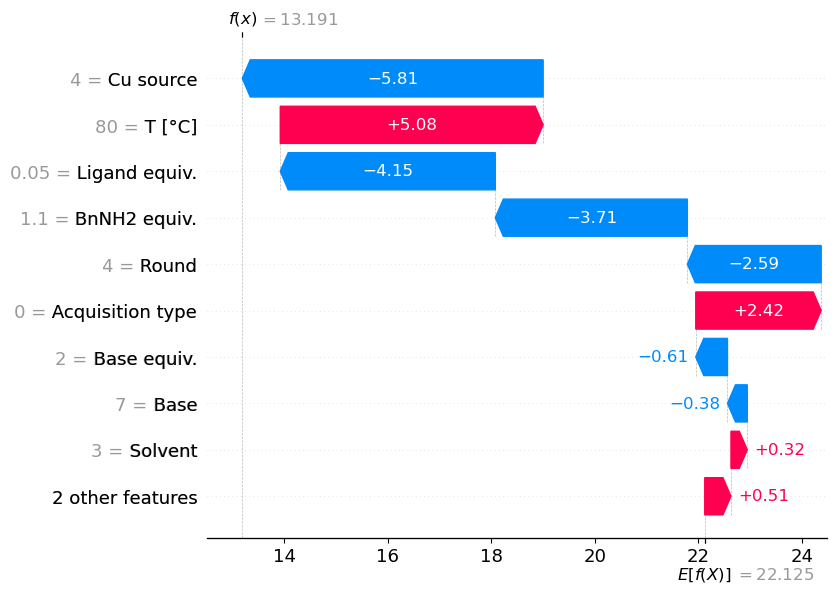

In [38]:
shap_values = explainer(x_val)
shap.plots.waterfall(shap_values[0])

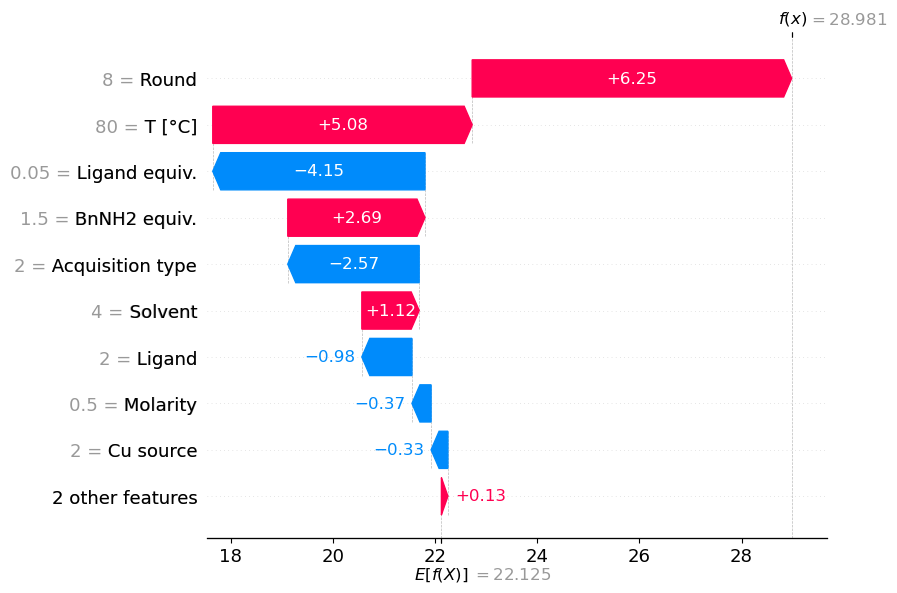

In [39]:
shap.waterfall_plot(shap_values[1])

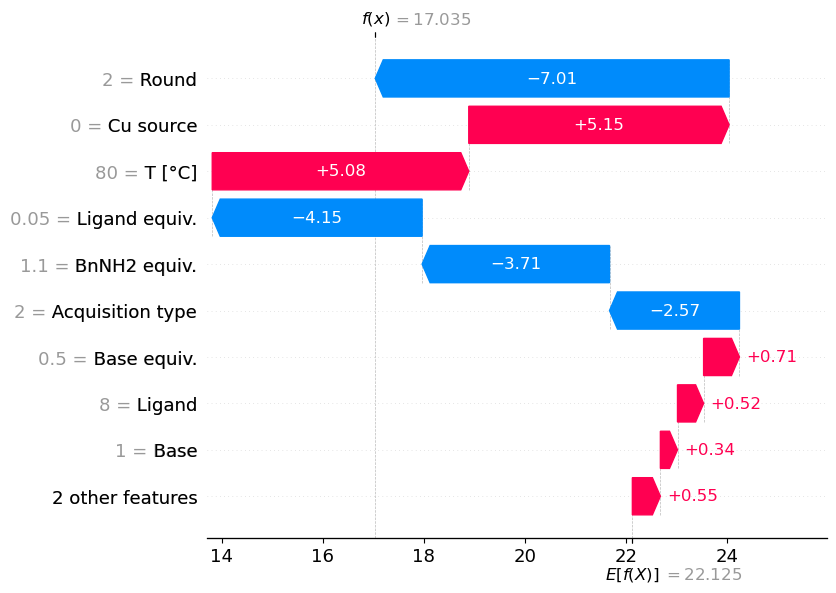

In [40]:
shap.waterfall_plot(shap_values[2])

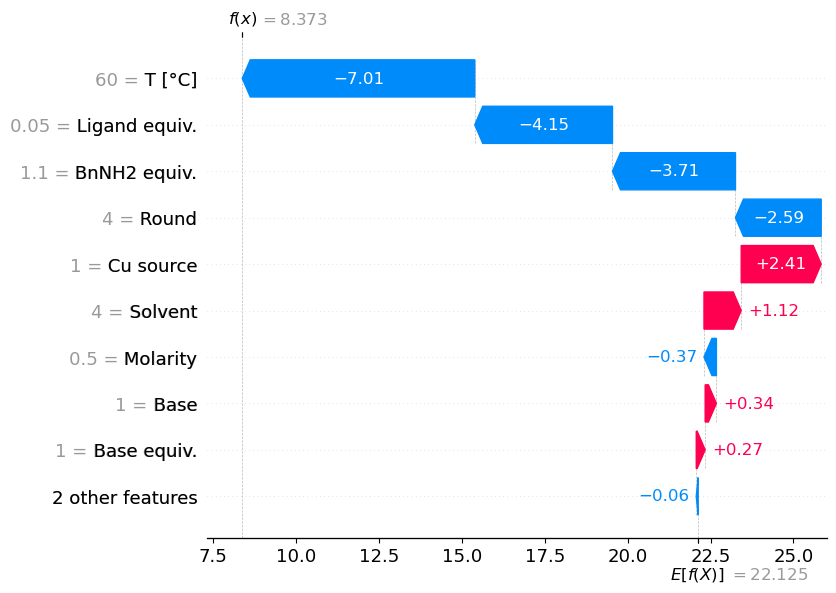

In [41]:
shap.waterfall_plot(shap_values[3])

Out of curiosity, wanted to see if the predictions got better through the sample but that doesn't seem to be the case.

The features the program struggles with aren't always the same, but round, temperature, ligand equivalent and BnNH2 equivalent are often present at the top.

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


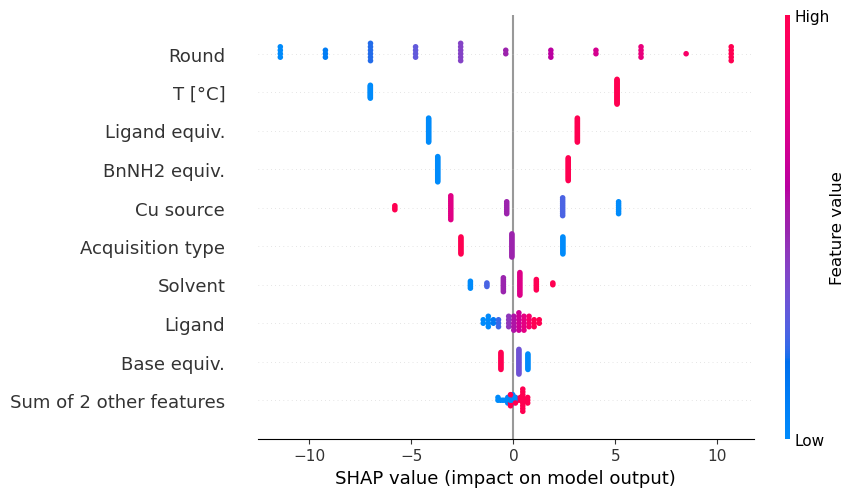

In [46]:
shap.plots.beeswarm(shap_values)

- As the round progresses, the yield becomes higher
- A higher temperature leads to a higher yield
- A higher ligand equivalent leads to a higher yield
- A higher BnNH2 equivalent leads to a higher yield
- A lower base equivalent leads to a higher yield
u

The indexing here is the same as the one from catboost_SHAP_test_01.ipynb

The best parameters are not necessarily the ones with the highest SHAP value ! See the Acquisition type : despite leading to the highest yield, EI has a lower SHAP value than TS. This is due to its results not being satisfactory until the latter rounds of the experiment.

The SHAP value is just a measure of whether a parameter tends to make the yield higher or lower when it is present. Qualitatively, this graph fits the observations from data_exploration.ipynb.

Here the features are in order of impact; as such the most important feature is seen to be the round, and the ones with the lowest SHAP values are the base and the molarity.

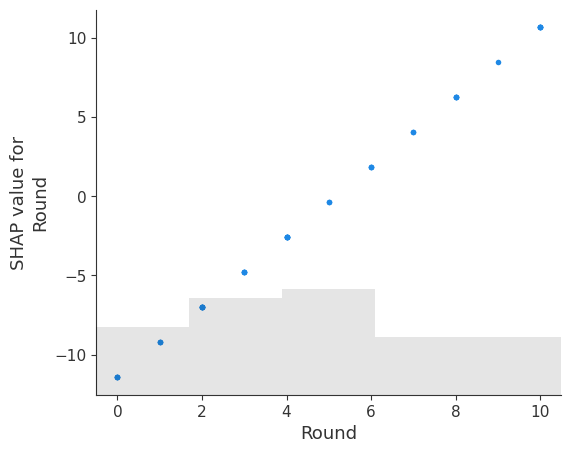

In [49]:
shap.plots.scatter(shap_values[:, 'Round'])

## SHAP values for the testing set
(not a lot of differences from validation set, kind of an addendum)

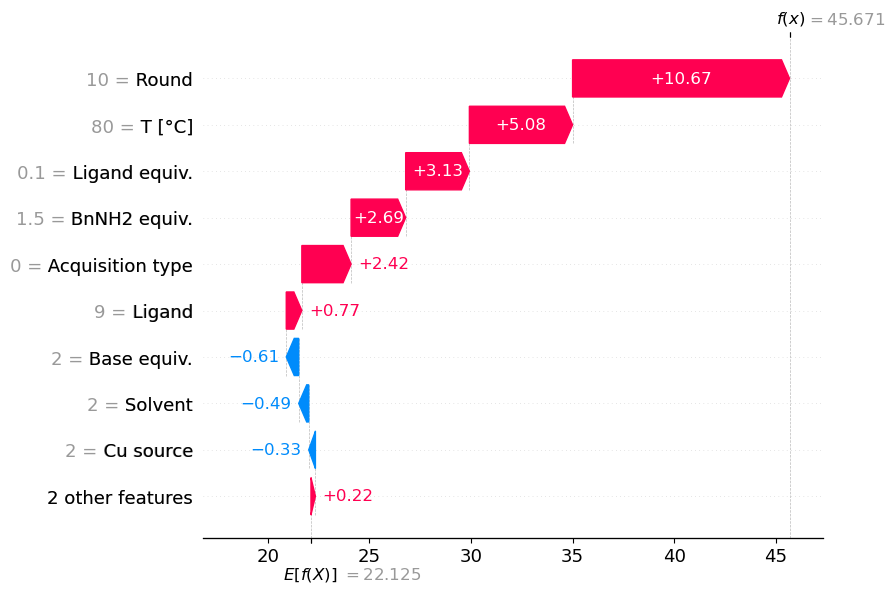

In [42]:
shap_values_test = explainer(x_test)
shap.plots.waterfall(shap_values_test[0])

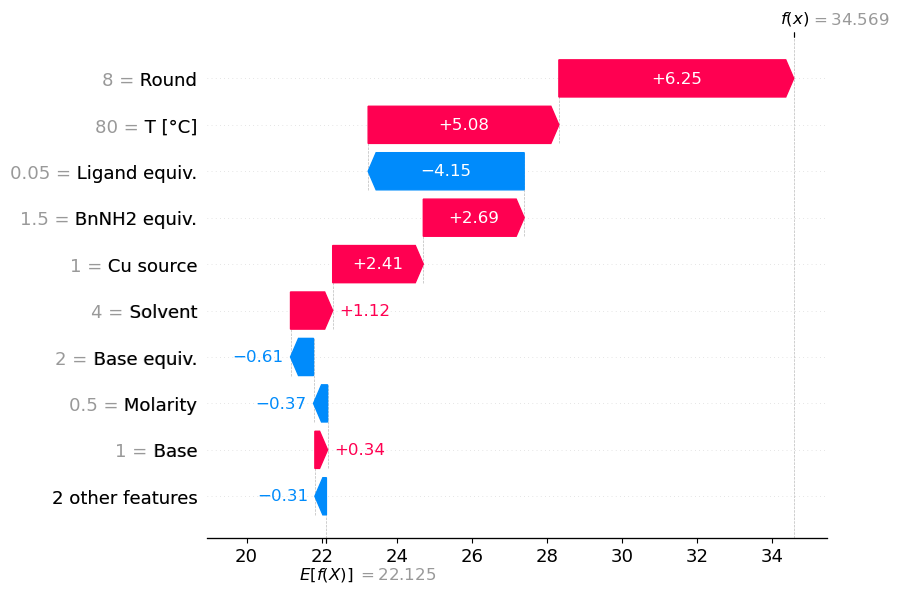

In [43]:
shap.plots.waterfall(shap_values_test[1])

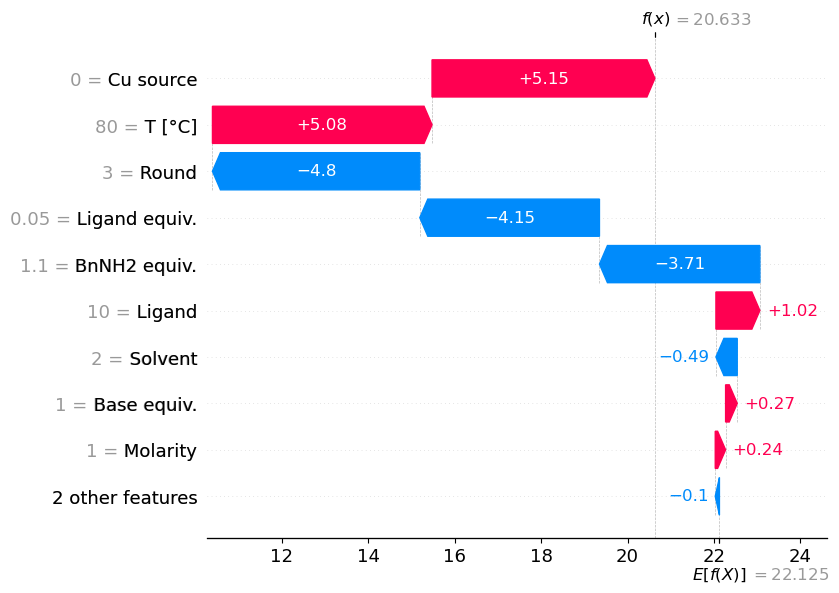

In [44]:
shap.plots.waterfall(shap_values_test[2])

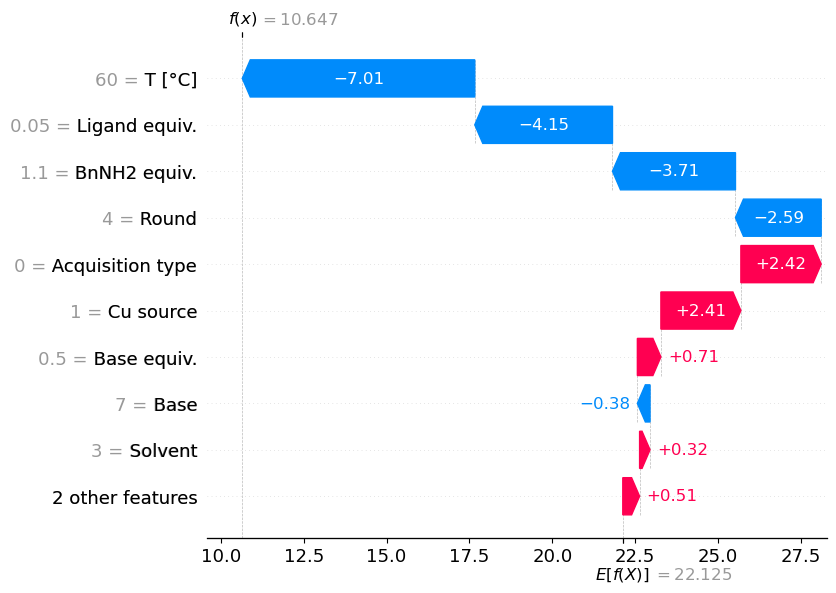

In [45]:
shap.plots.waterfall(shap_values_test[3])

The results here are similar to the ones from the validation set.

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


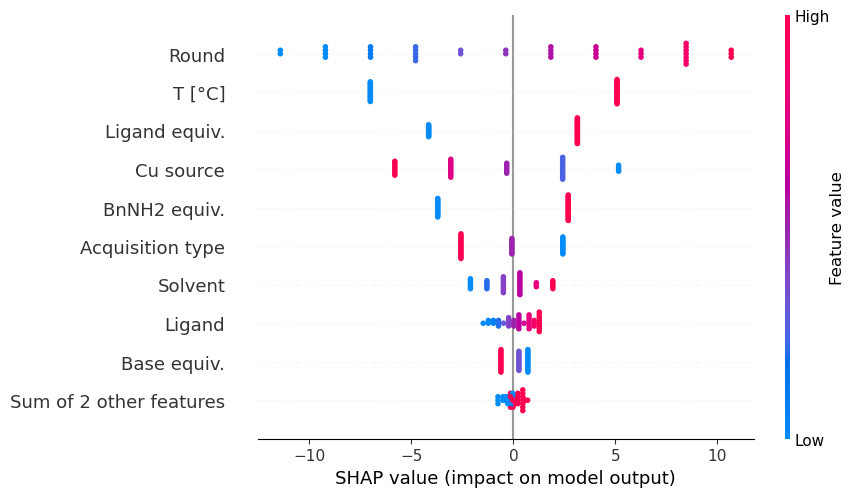

In [50]:
shap.plots.beeswarm(shap_values_test)

Very similar to the one of the validation set